In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
repo_root = "../"
import sys
sys.path.append(repo_root)

In [3]:
import numpy as numpy
import pandas as pd
import xgboost as xgb
import hyperopt as hpt
from preprocessing.country_and_airports_codes import compute_lon_lat,group_and_rename_countries, group_and_rename_airports, group_and_rename_aircraft_types
from preprocessing.encoding import one_hot_encoding,string_to_value_count, string_to_int_hashing
from preprocessing.local_time import add_localtime_to_train_and_test

In [4]:
space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
         'gamma': hpt.hp.uniform('gamma', 0.1, 5),
         'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
         'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
         'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
         'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
         'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
         'subsample': hpt.hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
         'seed': 0}

In [5]:
import os
print(os.getcwd())

/Users/leo/Desktop/Computer_fun/OpenSkyNet/repo3/ATOW_ML/notebooks


In [55]:
train_df = pd.read_csv("../data/challenge_set.csv")
test_df = pd.read_csv("../data/submission_set.csv")

In [56]:
add_localtime_to_train_and_test(train_df,test_df) #add localtime features (departures & arrival hours, day of years, weeks, month)
compute_lon_lat(train_df, test_df) # computes lon, lat for each airport
group_and_rename_countries(train_df, test_df) # simplify country_codes by group and rename countries
group_and_rename_airports(train_df, test_df) # simplify airport codes by group and rename airport
group_and_rename_aircraft_types(train_df, test_df) #regroup less used airlines and create "XXXX" category for unknown ones.


----------------------------------------------------------------------------------------------------
Columns for lon & lat: ['lon_adep', 'lat_adep', 'lon_ades', 'lat_ades'] successfully created !
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Country codes successfully grouped ! Different codes left : 47
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Airports codes successfully grouped ! Different codes left : 155
----------------------------------------------------------------------------------------------------


In [57]:
# encoding

columns_to_ohe = [] # A changer
train_df, test_df = one_hot_encoding(train_df, test_df, columns_to_ohe)

columns_to_hash = [] # A changer
string_to_int_hashing(train_df, test_df, columns_to_hash)

columns_to_vc = ['aircraft_type', 'callsign','country_code_ades', 'country_code_adep', 'adep', 'ades', 'airline','wtc'] # A changer
string_to_value_count(train_df, test_df, columns_to_vc)


----------------------------------------------------------------------------------------------------
Columns [] sucessfully one hot encoded !
----------------------------------------------------------------------------------------------------
        flight_id        date                          callsign  adep  \
0       248753821  2022-01-01  3b3de0f3ad0ee192513995c02f7bf7cf  LTFJ   
1       248753822  2022-01-01  e06dd03d4a879ca37d9e18c1bd7cad16  EBBR   
2       248754498  2022-01-01  2d3b1c962c78c4ebeef11bcd51b9e94c  KMIA   
3       248763650  2022-01-01  35f7721f68bf85128195547ae38b0f04  EBBR   
4       248763651  2022-01-01  eb56918bee9bc5204624186b9bcc4391  LSZH   
...           ...         ...                               ...   ...   
158144  258068876  2022-12-31  c9fca302ca2e28acab0eb0bb1b46f11b  LTFM   
158145  258064675  2022-12-31  00f96ad0e382476649574ba044c764fc  EHAM   
158146  258065436  2022-12-31  87c552b7f6d9bbd16a66e95df761c7f2  LEBL   
158147  258058138  2022-12-

In [58]:
# drop unusefull column:
to_drop = ['flight_id','date','name_adep','name_ades','name_adep','actual_offblock_time','arrival_time','local_departure_time','local_arrival_time']
train_df = train_df.drop(columns= to_drop)
test_df = test_df.drop(columns= to_drop)

In [59]:
X = train_df.drop(columns=['tow'])
y = train_df['tow']

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)


print(y_test)

display(X_train)

Train shape:  (295210, 20)
Test shape:  (73803, 20)
360642     78793.000000
362899    161373.000000
29041      59859.000000
27883      46853.000000
198546     59827.152595
              ...      
204954    220632.000000
42079      70694.000000
141949    188305.000000
158625     20944.000000
3440       57851.000000
Name: tow, Length: 73803, dtype: float64


,callsign,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,local_arrival_hour,local_departure_hour,travel_day_of_week,travel_day_of_year,departure_month,lon_adep,lat_adep,lon_ades,lat_ades
217511,5468,81,1,63,13,10,0,7,137,5,921,9,6,2,229,8,-4.43306,55.87190,10.88850,45.39570
138479,5507,134,5,8,5,0,0,1,117,5,744,22,20,2,159,6,29.89130,69.72580,11.10040,60.19390
249849,204,7,1,72,9,5,0,4,59,25,333,11,9,0,255,9,-0.46194,51.47060,-8.92482,52.70200
247970,2207,1,2,70,11,3,0,2,133,8,927,12,10,6,254,9,16.56970,48.11030,1.37312,38.87290
218954,1365,0,0,69,26,10,0,0,66,16,307,14,13,3,230,8,28.75200,41.27533,23.41144,42.69669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,524,84,0,0,0,0,0,0,57,10,289,22,21,0,353,12,27.66430,37.25060,28.75200,41.27533
358083,1811,113,8,127,11,4,0,10,130,5,861,9,7,5,351,12,4.46028,51.18940,-1.12500,37.80300
152315,19,11,13,5,9,0,0,4,79,19,460,11,11,6,170,6,2.55000,49.01280,-6.27007,53.42130
117952,6610,80,14,76,5,1,0,1,230,20,1544,15,12,5,141,5,24.14970,35.53170,8.08537,58.20420


In [60]:
def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            enable_categorical=True,
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(X_train, y_train), (X_test, y_test)]

    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(X_test)

    score = root_mean_squared_error(y_test, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}

trials = hpt.Trials()
best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=100, trials=trials)

SCORE:                                                 
3188.3143630194036                                     
SCORE:                                                                             
3419.5121483592998                                                                 
SCORE:                                                                             
4137.809792256661                                                                
SCORE:                                                                           
3328.77899732491                                                                 
SCORE:                                                                           
3883.3159332869877                                                               
SCORE:                                                                           
3544.3342779816285                                                               
SCORE:                                                        

In [61]:
display(best)

{'colsample_bytree': 0.9095379620568887,
 'gamma': 4.208836712689966,
 'learning_rate': 0.11097733292504518,
 'max_depth': 10.0,
 'min_child_weight': 2.0,
 'n_estimators': 810.0,
 'reg_alpha': 3.459312025167502,
 'reg_lambda': 3.786774257080584,
 'subsample': 0.6966962204381801}

In [62]:
# train xgboost with best hyperparameters

clf = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                        max_depth=int(best['max_depth']),
                        gamma=best['gamma'],
                        reg_alpha=best['reg_alpha'],
                        reg_lambda=best['reg_lambda'],
                        learning_rate=best['learning_rate'],
                        min_child_weight=best['min_child_weight'],
                        subsample=best['subsample'],
                        colsample_bytree=best['colsample_bytree'],
                        seed=0,
                        objective="reg:squarederror",
                        eval_metric="rmse",
                        early_stopping_rounds=10,
                        n_jobs=-1)

eval_set = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# predict on test set

y_pred = clf.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)

display(y_pred)
print("SCORE: ", score)

[0]	validation_0-rmse:47420.06754	validation_1-rmse:47414.65871
[1]	validation_0-rmse:42377.09139	validation_1-rmse:42365.50633
[2]	validation_0-rmse:37759.60819	validation_1-rmse:37744.75804
[3]	validation_0-rmse:33662.73974	validation_1-rmse:33647.34406
[4]	validation_0-rmse:30021.03257	validation_1-rmse:30003.01753
[5]	validation_0-rmse:26784.98706	validation_1-rmse:26765.11011
[6]	validation_0-rmse:23913.80688	validation_1-rmse:23891.91395
[7]	validation_0-rmse:21444.18367	validation_1-rmse:21423.25630
[8]	validation_0-rmse:19179.07027	validation_1-rmse:19157.31178
[9]	validation_0-rmse:17176.76928	validation_1-rmse:17157.65540
[10]	validation_0-rmse:15408.43935	validation_1-rmse:15391.27053
[11]	validation_0-rmse:13846.29950	validation_1-rmse:13830.99240
[12]	validation_0-rmse:12465.95904	validation_1-rmse:12454.45067
[13]	validation_0-rmse:11250.56767	validation_1-rmse:11242.92648
[14]	validation_0-rmse:10183.72640	validation_1-rmse:10182.00303
[15]	validation_0-rmse:9277.50791	v

array([ 78718.76 , 168352.47 ,  60893.74 , ..., 178773.7  ,  20104.277,
        54885.74 ], dtype=float32)

SCORE:  3160.7626151616246


In [63]:
# compute the root mean squared error

print("RMSE: ", score)

RMSE:  3160.7626151616246


Average relative error: 0.027406886782982427
Average absolute error: 2006.6346533806447


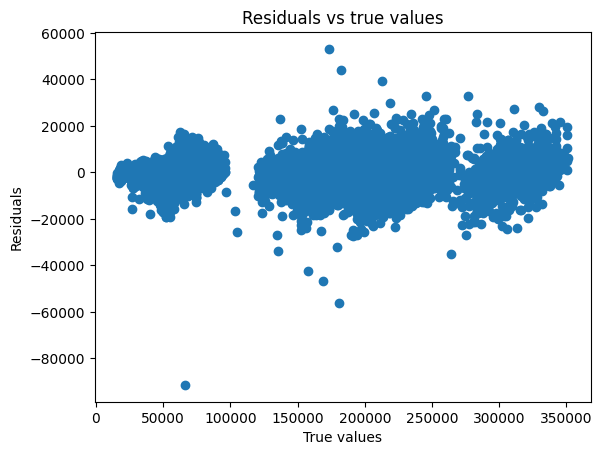

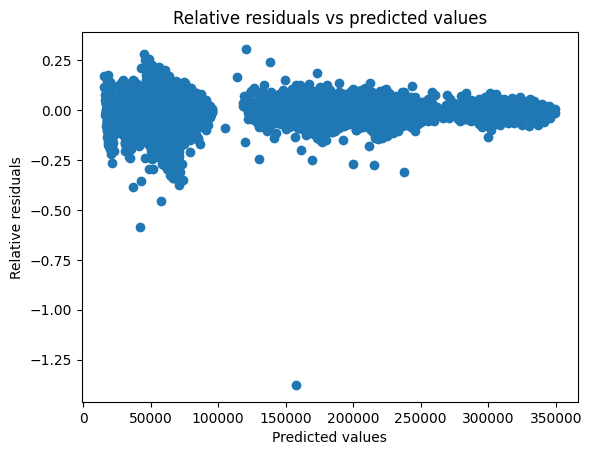

In [64]:
import matplotlib.pyplot as plt

# compute average relative error

relative_error = abs(y_test - y_pred) / y_test

average_relative_error = relative_error.mean()

print(f"Average relative error: {average_relative_error}")

# compute average absolute error

absolute_error = abs(y_test - y_pred)

average_absolute_error = absolute_error.mean()

print(f"Average absolute error: {average_absolute_error}")

# plot residuals vs true values

plt.scatter(y_test, (y_test-y_pred))

plt.xlabel("True values")

plt.ylabel("Residuals")

plt.title("Residuals vs true values")

plt.show()

# plot residuals vs predicted values

plt.scatter(y_pred, (y_test-y_pred)/y_test)

plt.xlabel("Predicted values")

plt.ylabel("Relative residuals")

plt.title("Relative residuals vs predicted values")

plt.show()



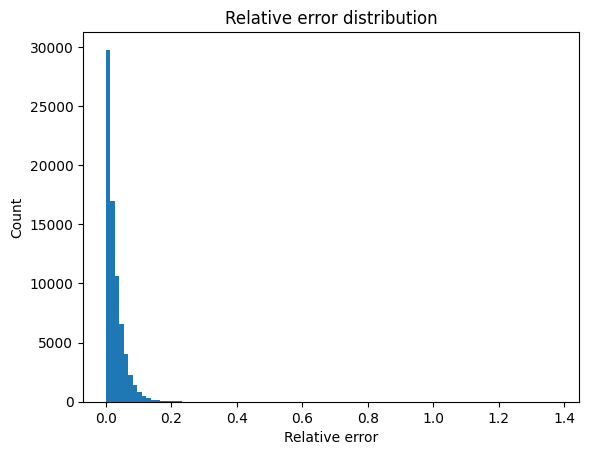

In [65]:
#plot relative error distribution

plt.hist(relative_error, bins=100)

plt.xlabel("Relative error")

plt.ylabel("Count")

plt.title("Relative error distribution")

plt.show()

# plot absolute error distribution

In [66]:
print(relative_error.mean())

0.027406886782982427


In [67]:
# same optimization on retriced set wtc = 1

x_train_wtc1 = X_train[X_train['wtc'] == 1]

y_train_wtc1 = y_train[X_train['wtc'] == 1]

x_test_wtc1 = X_test[X_test['wtc'] == 1]

y_test_wtc1 = y_test[X_test['wtc'] == 1]

space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
            'gamma': hpt.hp.uniform('gamma', 0.1, 5),
            'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
            'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
            'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
            'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
            'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hpt.hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
            'seed': 0}

def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(x_train_wtc1, y_train_wtc1), (x_test_wtc1, y_test_wtc1)]

    clf.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(x_test_wtc1)

    score = root_mean_squared_error(y_test_wtc1, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}


trials = hpt.Trials()

best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=20, trials=trials)

display(best)

SCORE:                                                
6410.694278058616                                     
SCORE:                                                                         
6344.930097034319                                                              
SCORE:                                                                         
6989.401663785188                                                              
SCORE:                                                                         
6952.936374456643                                                              
SCORE:                                                                         
6654.780052751037                                                              
SCORE:                                                                         
8016.136407422176                                                              
SCORE:                                                                         
6353.13817

{'colsample_bytree': 0.7742582625040466,
 'gamma': 0.1934453005179302,
 'learning_rate': 0.11410570139544009,
 'max_depth': 9.0,
 'min_child_weight': 7.0,
 'n_estimators': 603.0,
 'reg_alpha': 3.8397717454226497,
 'reg_lambda': 2.7446725470237094,
 'subsample': 0.7267927261905842}

In [68]:
# train xgboost with best hyperparameters

clf_wtc1 = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            learning_rate=best['learning_rate'],
                            min_child_weight=best['min_child_weight'],
                            subsample=best['subsample'],
                            colsample_bytree=best['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)

eval_set = [(x_train_wtc1, y_train_wtc1), (x_test_wtc1, y_test_wtc1)]

clf_wtc1.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=True)

# predict on test set

y_pred_wtc1 = clf_wtc1.predict(x_test_wtc1)

score = root_mean_squared_error(y_pred_wtc1, y_test_wtc1)
                       

[0]	validation_0-rmse:37307.53495	validation_1-rmse:37123.05070
[1]	validation_0-rmse:33680.12936	validation_1-rmse:33541.03202
[2]	validation_0-rmse:30107.43126	validation_1-rmse:29990.24721
[3]	validation_0-rmse:26965.76483	validation_1-rmse:26869.01963
[4]	validation_0-rmse:24206.14984	validation_1-rmse:24127.25139
[5]	validation_0-rmse:21761.40183	validation_1-rmse:21706.15507
[6]	validation_0-rmse:19629.35624	validation_1-rmse:19598.08133
[7]	validation_0-rmse:18057.85798	validation_1-rmse:18061.72130
[8]	validation_0-rmse:16387.13836	validation_1-rmse:16411.33191
[9]	validation_0-rmse:14944.15055	validation_1-rmse:14995.34756
[10]	validation_0-rmse:13691.13994	validation_1-rmse:13769.92565
[11]	validation_0-rmse:12599.15502	validation_1-rmse:12709.74671
[12]	validation_0-rmse:11657.96182	validation_1-rmse:11801.17297
[13]	validation_0-rmse:10856.60886	validation_1-rmse:11034.54364
[14]	validation_0-rmse:10174.00999	validation_1-rmse:10384.87091
[15]	validation_0-rmse:9655.68600	v

In [69]:
# same optimization on retriced set wtc = 0

x_train_wtc0 = X_train[X_train['wtc'] == 0]

y_train_wtc0 = y_train[X_train['wtc'] == 0]

x_test_wtc0 = X_test[X_test['wtc'] == 0]

y_test_wtc0 = y_test[X_test['wtc'] == 0]

space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
            'gamma': hpt.hp.uniform('gamma', 0.1, 5),
            'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
            'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
            'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
            'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
            'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hpt.hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
            'seed': 0}

def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(x_train_wtc0, y_train_wtc0), (x_test_wtc0, y_test_wtc0)]

    clf.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(x_test_wtc0)

    score = root_mean_squared_error(y_test_wtc0, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}


trials = hpt.Trials()

best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=100, trials=trials)

display(best)

SCORE:                                                 
3441.752420205054                                      
SCORE:                                                                          
2932.672802611419                                                               
SCORE:                                                                          
2272.383117182344                                                               
SCORE:                                                                          
2865.738673781085                                                               
SCORE:                                                                          
2528.804700868692                                                               
SCORE:                                                                          
2563.0456839726357                                                              
SCORE:                                                                        

{'colsample_bytree': 0.7443277166780795,
 'gamma': 2.5439991510343205,
 'learning_rate': 0.12793879162134636,
 'max_depth': 10.0,
 'min_child_weight': 4.0,
 'n_estimators': 776.0,
 'reg_alpha': 1.7172879369569998,
 'reg_lambda': 1.9427629363010985,
 'subsample': 0.9730054162870625}

In [70]:
# train xgboost with best hyperparameters

clf_wtc0 = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            learning_rate=best['learning_rate'],
                            min_child_weight=best['min_child_weight'],
                            subsample=best['subsample'],
                            colsample_bytree=best['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)

eval_set = [(x_train_wtc0, y_train_wtc0), (x_test_wtc0, y_test_wtc0)]

clf_wtc0.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=True)

# predict on test set

y_pred_wtc0 = clf_wtc0.predict(x_test_wtc0)

score = root_mean_squared_error(y_pred_wtc0, y_test_wtc0)

# compute the root mean squared error

print("RMSE: ", score)

[0]	validation_0-rmse:12326.06022	validation_1-rmse:12277.28662
[1]	validation_0-rmse:11167.25984	validation_1-rmse:11131.03409
[2]	validation_0-rmse:9863.78205	validation_1-rmse:9837.24922
[3]	validation_0-rmse:8736.48838	validation_1-rmse:8719.95333
[4]	validation_0-rmse:7768.96984	validation_1-rmse:7762.71978
[5]	validation_0-rmse:6945.22558	validation_1-rmse:6948.22110
[6]	validation_0-rmse:6233.86685	validation_1-rmse:6245.43747
[7]	validation_0-rmse:5775.98285	validation_1-rmse:5796.27366
[8]	validation_0-rmse:5237.00243	validation_1-rmse:5266.47942
[9]	validation_0-rmse:4784.58975	validation_1-rmse:4823.22237
[10]	validation_0-rmse:4409.23480	validation_1-rmse:4456.08012
[11]	validation_0-rmse:4087.89442	validation_1-rmse:4144.11981
[12]	validation_0-rmse:3824.68867	validation_1-rmse:3889.84966
[13]	validation_0-rmse:3608.27879	validation_1-rmse:3681.97737
[14]	validation_0-rmse:3430.49047	validation_1-rmse:3512.28475
[15]	validation_0-rmse:3317.46811	validation_1-rmse:3406.6570

In [71]:
y_pred_wtc0 = clf_wtc0.predict(X_test)

y_pred_wtc1 = clf_wtc1.predict(X_test)

y_pred = clf.predict(X_test)

y_pred_aggregate = (y_pred_wtc0 * (X_test['wtc'] == 0) + y_pred_wtc1 * (X_test['wtc'] == 1) + y_pred)/2

In [72]:
# compute the root mean squared error

score = root_mean_squared_error(y_pred_aggregate, y_test)
print("RMSE: ", score)

RMSE:  3095.9424188866556


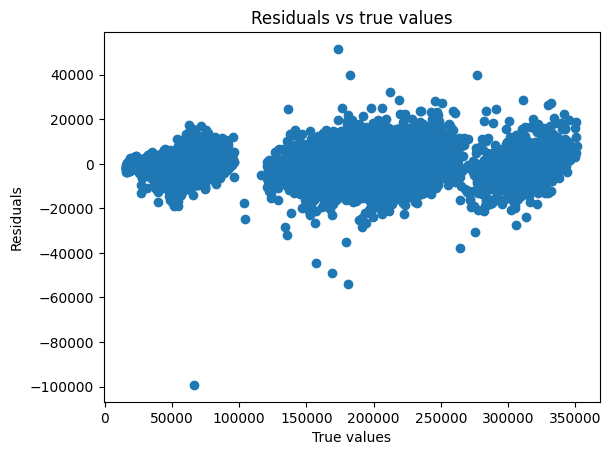

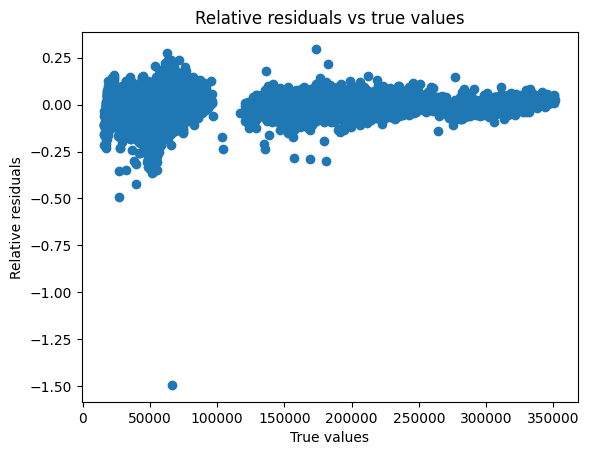

In [73]:
# plot residuals vs true values

plt.scatter(y_test, (y_test-y_pred_aggregate))

plt.xlabel("True values")

plt.ylabel("Residuals")

plt.title("Residuals vs true values")

plt.show()

# plot relative error vs true values

plt.scatter(y_test, (y_test-y_pred_aggregate)/y_test)

plt.xlabel("True values")

plt.ylabel("Relative residuals")

plt.title("Relative residuals vs true values")

plt.show()



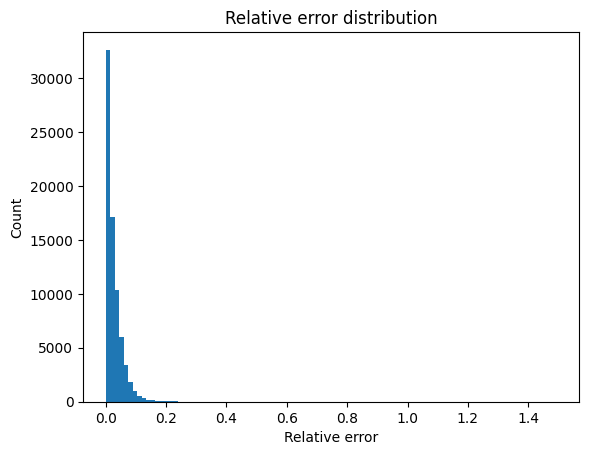

In [74]:
# plot relative error distribution

plt.hist(abs(y_test - y_pred_aggregate) / y_test, bins=100)

plt.xlabel("Relative error")

plt.ylabel("Count")

plt.title("Relative error distribution")

plt.show()



In [ ]:
# print average relative error

relative_error = abs(y_test - y_pred_aggregate) / y_test

average_relative_error = relative_error.mean()

print(f"Average relative error: {average_relative_error}")

# print average absolute error

absolute_error = abs(y_test - y_pred_aggregate)

average_absolute_error = absolute_error.mean()

print(f"Average absolute error: {average_absolute_error}")

seuil = 0.05

print(f"Percentage of predictions with relative error below {seuil}: {100 * (relative_error < seuil).mean()}")

print(f"Percentage of predictions with relative error below {2*seuil}: {100 * (relative_error < 2*seuil).mean()}")

print(f"Percentage of predictions with relative error below {3*seuil}: {100 * (relative_error < 3*seuil).mean()}")

In [75]:
# retrain the model on all the dataset without early stopping

basic_param = {'colsample_bytree': 0.9362150768343058,
 'gamma': 2.022211195429398,
 'learning_rate': 0.07900609044575752,
 'max_depth': 10.0,
 'min_child_weight': 1.0,
 'n_estimators': 862.0,
 'reg_alpha': 1.6659492680583492,
 'reg_lambda': 4.4589665080717085,
 'subsample': 0.7470405034939882}

clf = xgb.XGBRegressor(n_estimators=int(basic_param['n_estimators']),
                            max_depth=int(basic_param['max_depth']),
                            gamma=basic_param['gamma'],
                            reg_alpha=basic_param['reg_alpha'],
                            reg_lambda=basic_param['reg_lambda'],
                            learning_rate=basic_param['learning_rate'],
                            min_child_weight=basic_param['min_child_weight'],
                            subsample=basic_param['subsample'],
                            colsample_bytree=basic_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

eval_set = [(X, y)]

clf.fit(X, y, eval_set=eval_set, verbose=False)

wtc0_param = {'colsample_bytree': 0.8497066984064998,
 'gamma': 1.8567356656935454,
 'learning_rate': 0.041891010160377044,
 'max_depth': 9.0,
 'min_child_weight': 8.0,
 'n_estimators': 859.0,
 'reg_alpha': 3.709715865940738,
 'reg_lambda': 1.6089032820385571,
 'subsample': 0.8005286414941816}


clf_wtc0 = xgb.XGBRegressor(n_estimators=int(wtc0_param['n_estimators']),
                            max_depth=int(wtc0_param['max_depth']),
                            gamma=wtc0_param['gamma'],
                            reg_alpha=wtc0_param['reg_alpha'],
                            reg_lambda=wtc0_param['reg_lambda'],
                            learning_rate=wtc0_param['learning_rate'],
                            min_child_weight=wtc0_param['min_child_weight'],
                            subsample=wtc0_param['subsample'],
                            colsample_bytree=wtc0_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

x_train_wtc0 = X[X['wtc'] == 0]

y_train_wtc0 = y[X['wtc'] == 0]

eval_set = [(x_train_wtc0, y_train_wtc0)]

clf_wtc0.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=False)

wtc1_param = {'colsample_bytree': 0.9865346417369687,
 'gamma': 2.311730004603916,
 'learning_rate': 0.1355408626893648,
 'max_depth': 9.0,
 'min_child_weight': 2.0,
 'n_estimators': 890.0,
 'reg_alpha': 2.7683944404030436,
 'reg_lambda': 0.10259397496527922,
 'subsample': 0.6971029355383804}

clf_wtc1 = xgb.XGBRegressor(n_estimators=int(wtc1_param['n_estimators']),
                            max_depth=int(wtc1_param['max_depth']),
                            gamma=wtc1_param['gamma'],
                            reg_alpha=wtc1_param['reg_alpha'],
                            reg_lambda=wtc1_param['reg_lambda'],
                            learning_rate=wtc1_param['learning_rate'],
                            min_child_weight=wtc1_param['min_child_weight'],
                            subsample=wtc1_param['subsample'],
                            colsample_bytree=wtc1_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

x_train_wtc1 = X[X['wtc'] == 1]

y_train_wtc1 = y[X['wtc'] == 1]

eval_set = [(x_train_wtc1, y_train_wtc1)]

clf_wtc1.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=False)



y_pred_wtc0 = clf_wtc0.predict(test_df)

y_pred_wtc1 = clf_wtc1.predict(test_df)

y_pred = clf.predict(test_df)

y_pred_aggregate = (y_pred_wtc0 * (test_df['wtc'] == 0) + y_pred_wtc1 * (test_df['wtc'] == 1) + y_pred)/2





ValueError: feature_names mismatch: ['callsign', 'adep', 'country_code_adep', 'ades', 'country_code_ades', 'aircraft_type', 'wtc', 'airline', 'flight_duration', 'taxiout_time', 'flown_distance', 'local_arrival_hour', 'local_departure_hour', 'travel_day_of_week', 'travel_day_of_year', 'departure_month', 'lon_adep', 'lat_adep', 'lon_ades', 'lat_ades'] ['callsign', 'adep', 'country_code_adep', 'ades', 'country_code_ades', 'aircraft_type', 'wtc', 'airline', 'flight_duration', 'taxiout_time', 'flown_distance', 'tow', 'local_arrival_hour', 'local_departure_hour', 'travel_day_of_week', 'travel_day_of_year', 'departure_month', 'lon_adep', 'lat_adep', 'lon_ades', 'lat_ades']
training data did not have the following fields: tow

In [ ]:
# plot clf model importance

import matplotlib.pyplot as plt

xgb.plot_importance(clf)

plt.show()

In [ ]:
# add y_pred_aggregate to test_df

test_df['tow'] = y_pred_aggregate

display(test_df)

## MLP with random search

In [24]:
from sklearn import neural_network, model_selection, metrics
import numpy as np

In [27]:
## GridSearch pour réseau de neurones

#Préparation du GridSearch
alpha_range = 10**(np.arange(-6.,0.,1)) #start, stop(excl.), step
n_neurons_range=((10,), (50,), (100,), (10,10), (50,50))
max_iter_range=(10, 50, 100, 200)
parameters={ 'alpha':alpha_range, 'hidden_layer_sizes':n_neurons_range, 'max_iter':max_iter_range}
MLP = neural_network.MLPRegressor(parameters, random_state=1)
randomsearch_MLP = model_selection.RandomizedSearchCV(MLP, parameters, n_jobs=-1)
#Réalisation du GridSearch sur les données
randomsearch_MLP.fit(X_train,y_train)
print("Avec normalisation, meilleur estimateur trouvé:")
print(randomsearch_MLP.best_estimator_)
print(f"Score sur la base de test: {randomsearch_MLP.score(X_test,y_test)}")

# Si on veut en plus regarder les matrices de confusion etc, il faut entraîner le modèle avec les données de best_estimator_:
MLP=neural_network.MLPClassifier(alpha=1e-2, hidden_layer_sizes=(50,50), max_iter=100, random_state=1, verbose=1)  #à remplacer avec nos paramètres
MLP.fit(X_train,y_train)
print("score MLP %.3f" % MLP.score(X_test, y_test) )
metrics.confusion_matrix(y_test, MLP.predict(X_test))

/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/

Avec normalisation, meilleur estimateur trouvé:
MLPRegressor(alpha=0.001, hidden_layer_sizes=(10, 10), random_state=1)
Score sur la base de test: 0.9824219858109015


ValueError: Unknown label type: (array([68875.        , 51862.        , 72707.        , ...,
       63179.41458733, 53775.        , 76676.00909005]),)

In [29]:

MLP1 = neural_network.MLPRegressor(alpha=0.001, hidden_layer_sizes=(10, 10), random_state=1)
MLP1.fit(X_train,y_train)

/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.001, hidden_layer_sizes=(10, 10), random_state=1)

In [53]:
print("score MLP %.3f" % MLP1.score(X_test, y_test) )


y_pred= MLP1.predict(X_test)
metrics.mean_squared_error(y_test, y_pred, squared=False)

score MLP 0.982


/Users/leo/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7060.222552439083

In [33]:
y_test

360642     78793.000000
362899    161373.000000
29041      59859.000000
27883      46853.000000
198546     59827.152595
              ...      
204954    220632.000000
42079      70694.000000
141949    188305.000000
158625     20944.000000
3440       57851.000000
Name: tow, Length: 73803, dtype: float64

In [34]:
y_pred

array([ 77595.67318832, 175792.59073511,  56149.80973483, ...,
       177491.50155351,  16005.08434158,  60641.29489348])

# MLP With Tensorflow

In [76]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2024-10-27 17:05:40.530218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
########################## DATA LOADING ########################

print("-"*100)
print("Start of the pipeline ! ")
print("-"*100)

train_df = pd.read_csv('../data/challenge_set.csv')	
test_df = pd.read_csv('../data/submission_set.csv')
    
########################## PREPROCESSING ########################

print("-"*100)
print("Start of the preprocessing ! ")
print("-"*100)

add_localtime_to_train_and_test(train_df,test_df) #add localtime features (departures & arrival hours, day of years, weeks, month)
compute_lon_lat(train_df, test_df) # computes lon, lat for each airport
group_and_rename_countries(train_df, test_df) # simplify country_codes by group and rename countries
group_and_rename_airports(train_df, test_df) # simplify airport codes by group and rename airport
group_and_rename_aircraft_types(train_df, test_df) #regroup less used airlines and create "XXXX" category for unknown ones.


########################## ENCODING #########################

print("-"*100)
print("Start of the encoding ! ")
print("-"*100)

columns_to_ohe = ['aircraft_type', 'country_code_ades', 'country_code_adep', 'adep', 'ades', 'airline'] # A changer
train_df, test_df = one_hot_encoding(train_df, test_df, columns_to_ohe)

columns_to_hash = [] # A changer
string_to_int_hashing(train_df, test_df, columns_to_hash)

columns_to_vc = [] # A changer
string_to_value_count(train_df, test_df, columns_to_vc)

/Users/leo/Desktop/Computer_fun/OpenSkyNet/repo3/ATOW_ML/notebooks
----------------------------------------------------------------------------------------------------
Start of the pipeline ! 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Start of the preprocessing ! 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Columns for lon & lat: ['lon_adep', 'lat_adep', 'lon_ades', 'lat_ades'] successfully created !
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Country codes successfully grouped ! Different codes left : 47
-------------

In [89]:
# drop unusefull column:
to_drop = ['flight_id','date','name_adep','name_ades','name_adep','actual_offblock_time','arrival_time','local_departure_time','local_arrival_time']
train_df = train_df.drop(columns= to_drop)
test_df = test_df.drop(columns= to_drop)

########################## DATA SPLITTING #######################

X = train_df.drop(columns=['tow'])
y = train_df['tow']

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X_train_MLP, X_test_MLP, y_train_MLP, y_test_MLP = train_test_split(X, y, test_size=0.2, random_state=0)


print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)


print(y_test)

display(X_train)

Train shape:  (295210, 20)
Test shape:  (73803, 20)
360642     78793.000000
362899    161373.000000
29041      59859.000000
27883      46853.000000
198546     59827.152595
              ...      
204954    220632.000000
42079      70694.000000
141949    188305.000000
158625     20944.000000
3440       57851.000000
Name: tow, Length: 73803, dtype: float64


array([[ 2.20600749,  1.84981396, -0.92606777, ...,  0.98604624,
         0.21190359, -0.44608462],
       [ 2.22872126,  3.56721995, -0.28775711, ...,  2.82842203,
         0.22065869,  1.58957344],
       [-0.85976842, -0.54807363, -0.92606777, ...,  0.40073463,
        -0.60672612,  0.55897873],
       ...,
       [-0.9675132 , -0.41845809,  0.98886421, ...,  0.07388145,
        -0.49703945,  0.6579265 ],
       [ 2.87111313,  1.81741008,  1.14844187, ..., -1.71891713,
         0.09608628,  1.31586794],
       [-0.97159003, -0.09441922,  0.82928654, ..., -0.88472208,
        -0.49703945,  0.6579265 ]])

In [90]:
scaler = StandardScaler()
X_train_MLP = scaler.fit_transform(X_train_MLP)
X_test_MLP = scaler.fit_transform(X_test_MLP)

ValueError: could not convert string to float: '84337df19a091f0c0053a19d00d07083'

In [78]:
model = tf.keras.Sequential([tf.keras.layers.Dense(30, activation = 'relu', input_shape = X_train_MLP.shape[1:]),
                            tf.keras.layers.Dense(1)])

/Users/leo/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
model.compile(loss = tf.losses.MSE,
             optimizer = 'sgd')

In [81]:
history = model.fit(X_train_MLP, y_train_MLP, epochs=20,
                   validation_data=(X_test_MLP, y_test_MLP))

Epoch 1/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 10s 997us/step - loss: nan - val_loss: nan
Epoch 2/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 6s 701us/step - loss: nan - val_loss: nan
Epoch 3/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: nan - val_loss: nan
Epoch 4/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: nan - val_loss: nan
Epoch 5/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 7s 730us/step - loss: nan - val_loss: nan
Epoch 6/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 6s 666us/step - loss: nan - val_loss: nan
Epoch 7/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 7s 786us/step - loss: nan - val_loss: nan
Epoch 8/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 9s 970us/step - loss: nan - val_loss: nan
Epoch 9/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: nan - val_loss: nan
Epoch 10/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: nan - val_loss: nan
Epoch 11/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: nan - val_loss: nan
Epoch 12/20
9226/9226 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: nan - val_loss

In [82]:
mean_squared_error_test = model.evaluate(X_test_MLP, y_test_MLP)
x_new = X_test_MLP[:3] # New instance
y_pred = model.predict(x_new)
y_pred

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 2s 917us/step - loss: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


array([[nan],
       [nan],
       [nan]], dtype=float32)